In [1]:
import torch
import numpy as np
import random
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
plt.style.use('ggplot')

We will try our own toy transative closure to test their methods. We will use the Stanford Encyclopedia of Philosophy ontology kept by the Indiana Philosophy Ontology project (https://inpho.cogs.indiana.edu/).

We'll use a subtree that looks like this:

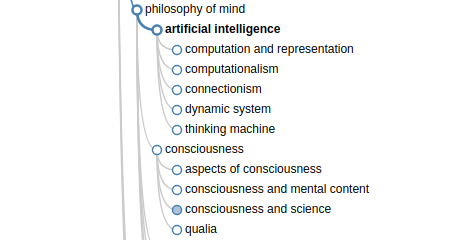

In [92]:
vocab_dict = {
    'philosophy of mind': 0,
    'artificial intelligence': 1,
    'computation and representation': 2,
    'computationalism': 3,
    'connectionism': 4,
    'dynamic system': 5,
    'thinking machine': 6,
    'consciousness': 7,
    'aspects of consciousness': 8,
    'consciousness and mental content': 9,
    'consciousness and science': 10,
    'qualia': 11}

The transitive closure matrix should then look like this:

In [3]:
trans_closure_undirected = np.array([
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],])
trans_closure_directed = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],])

In [5]:
# Global variables
vocab_size = trans_closure_directed.shape[0]
embed_dim = 2
stability = 1e-6

In [6]:
#
# Data preparation

def get_pos_pairs(closure, n_words):
    pos_pairs = []
    for u in range(n_words):
        children = [v for v in np.nonzero(closure[u])[0]]
        if len(children) > 0:
            pos_pairs += list(zip([u] * len(children), children))
    return pos_pairs

def neg_samples(u, v, n_negs, closure):
    children = [vp for vp in np.nonzero(closure[u])[0]]
    nonchildren = [vp for vp in range(vocab_size)
                   if (vp not in children)]  # will capture u as we are supposed to
    num_negs = min(len(nonchildren), n_negs)
    return random.sample(nonchildren, num_negs)

def epoch_data(n_negs, n_words, closure):
    pos_pairs = get_pos_pairs(closure, n_words)
    # randomize order each epoch
    random.shuffle(pos_pairs)
    return [(u, v, neg_samples(u, v, n_negs, closure)) for u, v in pos_pairs]

In [7]:
#
# Math funcs

def arcosh(x):
    return torch.log(x + torch.sqrt(x**2 - 1))

def pdist(u, v):
    """Poincare distance."""
    uu = u.norm(dim=1)**2
    vv = v.norm(dim=1)**2
    uv = u.mm(v.t())
    numerator = uu - 2 * uv + vv
    denominator = (1 - uu).clamp(min=stability) * (1 - vv).clamp(min=stability)
    gamma = (1 + 2 * numerator / denominator).clamp(min=1 + stability)
    distance = arcosh(gamma)
    return distance

In [131]:
#
# Model

def loss(u, v, negs):
    """Loss for a positive pairs and negative samples.
    
    u, v, negs are all tensors by now (negs is matrix)
    """
    return -torch.log(torch.exp(-pdist(u, v)) / torch.exp(-pdist(u, negs)).sum())

In [136]:
#
# Optimization

def proj(theta):
    norm = theta.norm(p=2, dim=1).unsqueeze(1)
    norm[norm<1] = 1
    norm[norm>=1] += stability
    return theta.div(norm)

def scale_grad(delta):
    return ((1 - delta.norm()**2)**2) / 4. * delta

def update(embeds, lr, u_ix, v_ix, neg_ixs, u, v, negs):
    print(u.grad)
    raise Exception
    embeds[neg_ixs] -= lr*(((1-negs.norm(dim=1)**2)**2)/4.).data.unsqueeze(1)*negs.grad.data
    embeds[u_ix] -= lr*(((1-u.norm()**2)**2)/4.).data*u.grad.data
    embeds[v_ix] -= lr*(((1-v.norm()**2)**2)/4.).data*v.grad.data
    embeds = proj(embeds)

def forward(embeds, u_ix, v_ix, neg_ixs):
    """Calculate loss and gradient for the sample."""
    # unsqueezing yields row vectors; needed for vectorization of u.mm(negs^T) in pdist
    u = Variable(embeds[u_ix].unsqueeze(0), requires_grad=True)
    v = Variable(embeds[v_ix].unsqueeze(0), requires_grad=True)
    negs = Variable(embeds[neg_ixs], requires_grad=True)
    L = loss(u, v, negs)
    f_loss = L.data.numpy()[0][0]
    L.backward()
    return f_loss, u, v, negs

In [153]:
a = Variable(torch.from_numpy(np.array([0.1, 0.2])).unsqueeze(0), requires_grad=True)
b = Variable(torch.from_numpy(np.array([0.3, 0.1])).unsqueeze(0), requires_grad=True)
pdist(a, b)
negs = Variable(torch.from_numpy(np.array([[0.2, 0.1], [0.1, 0.3]])), requires_grad=True)
pdist(a, negs)
l = loss(a, b, negs)
l.backward()
a.grad

Variable containing:
-1.1511  1.3980
[torch.DoubleTensor of size 1x2]

In [133]:
def pplot(vdict, pembs, name='Philosophy Ontology'):
    fig = plt.figure(figsize=(10,10)); ax = plt.gca(); ax.cla()
    ax.set_xlim((-1.1,1.1)); ax.set_ylim((-1.1,1.1))
    ax.add_artist(plt.Circle((0,0),1.,color='black',fill=False))
    fliers = []
    for w, i in vdict.items():
        emb = pembs[i]
        if emb.norm() > 1.:
            fliers.append(w)
        else:
            c0, c1 = pembs[i]
            ax.plot(c0, c1, 'o', color='y')
            ax.text(c0 +.01, c1+.01, w, color='b')
    if len(fliers) > 0:
        print('Words that flew out of the ball:')
        for flier in fliers:
            print('  * %s' % flier)
    plt.show()

def plot_change(embs1, embs2, changed_ixs, vocab):
    import matplotlib.cm as cm
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.cla()
    
    max_norm = max(embs1.norm(p=2, dim=1).max(),
                   embs2.norm(p=2, dim=1).max())
    lim = max_norm * 1.1
    text_offset = max_norm / 100.

    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))
    
    circle = plt.Circle((0, 0), lim, color='black', fill=False)
    ax.add_artist(circle)
    
    colorspace = ['b', 'r', 'y', 'g', 'c', 'm', 'k']
    
    i = -1
    for word, ix in vocab.items():
        if ix in changed_ixs:
            i += 1
            x1, y1 = embs1[ix]
            x2, y2 = embs2[ix]
            ax.plot(x1, y1, 'o', color=colorspace[i])
            ax.plot(x2, y2, 'x', color=colorspace[i])
            ax.text(x2 + text_offset, y2 + text_offset, word, color='b', alpha=0.6)
    
    plt.show()

In [134]:
def train(embeds, closure, vdict, n_negs, lr1, lr2, plot=True):
    losses = []
    epoch = -1
    ix_to_word = {v: k for k, v in vocab_dict.items()}
    #while len(losses) < 1 or np.average(losses) > 0.01:
    while epoch < 100:
        if plot:
            pre = embeds.clone()
        epoch += 1
        print(epoch)
        data = epoch_data(n_negs, len(vdict), closure)
        r = 1. * epoch / 200; 
        rate = (1 - r) * lr1 + r * lr2
        if epoch < 10:
            rate = rate / 10
        for u_ix, v_ix, neg_ixs in data:
            print('%s -> %s ; %s' % (ix_to_word[u_ix], ix_to_word[v_ix], ', '.join([ix_to_word[ix] for ix in neg_ixs])))
            l, u, v, negs = forward(embeds, u_ix, v_ix, neg_ixs)
            losses.append(l)
            print('Loss: %s\tAverage: %s' % (l, np.average(losses)))
            update(embeds, rate, u_ix, v_ix, neg_ixs, u, v, negs)
            if plot:
                changed_ixs = [u_ix, v_ix] + neg_ixs
                plot_change(pre, embeds, changed_ixs, vdict)
                raise Exception()

0
computationalism -> artificial intelligence ; consciousness and mental content, thinking machine, qualia
Loss: 1.09895	Average: 1.09895


/home/hanshan/anaconda3/envs/py35/lib/python3.5/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


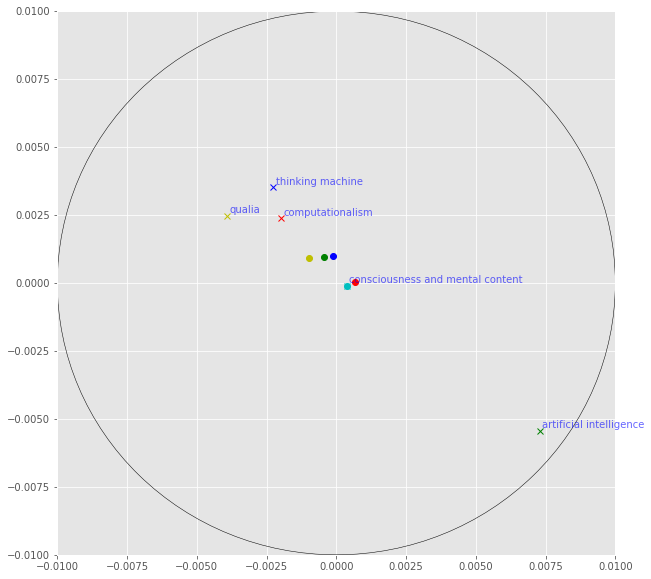

Exception: 

In [135]:
embeddings = torch.Tensor(vocab_size, embed_dim)
torch.nn.init.uniform(embeddings, a=-0.001, b=0.001)
train(embeddings, trans_closure_directed, vocab_dict, 3, 0.2, 0.01)

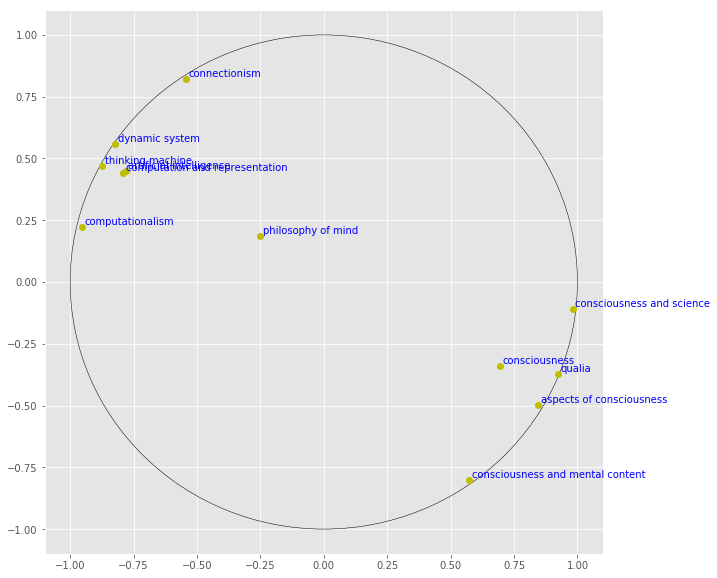

In [42]:
pplot(vocab_dict, embeddings)

0
connectionism -> artificial intelligence ; consciousness and mental content, consciousness and science, qualia
Loss: 1.09939	Average: 1.09939


/home/hanshan/anaconda3/envs/py35/lib/python3.5/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


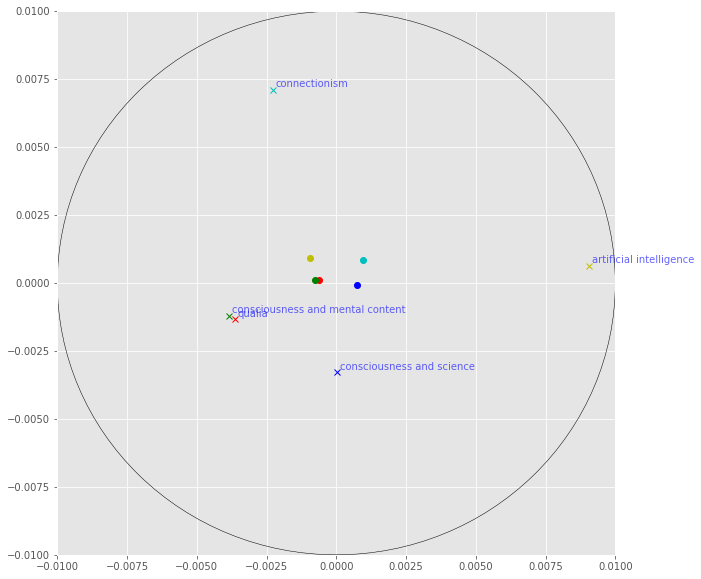

Exception: 

In [125]:
embeddings2 = torch.Tensor(vocab_size, embed_dim)
torch.nn.init.uniform(embeddings2, a=-0.001, b=0.001)
train(embeddings2, trans_closure_undirected, vocab_dict, 3, 0.2, 0.01)

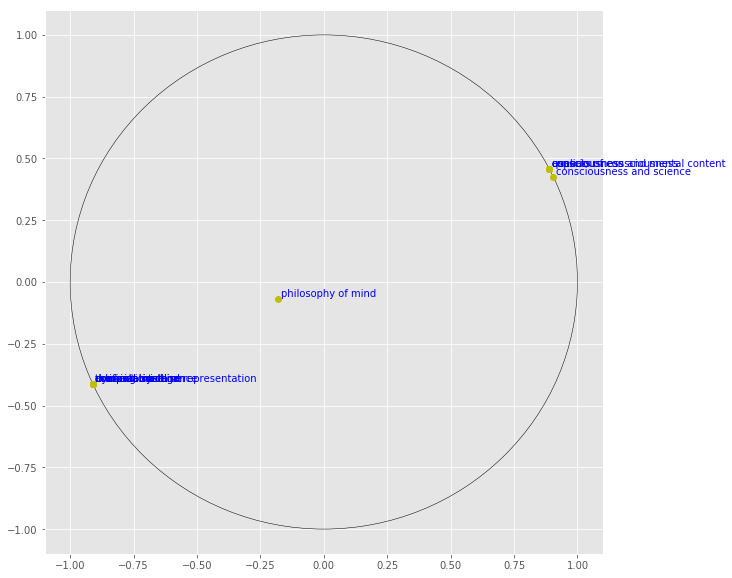

In [54]:
pplot(vocab_dict, embeddings2)

Interesting result: it looks like the higher number of nodes on the right pushes the root node off to the left.

I really don't like this loss function and I suspect a better one may be superior.

I should also try a larger tree. Although the smaller tree is a nice way to get a feel for the dynamics of the learning algorithm.

The undirected transitive closure is also bollocks. I need to double check that concept.

I also need to try the author's own dataset.

To do:
1) tidy this code
2) try and visualize how the learning algorithm works
3) double check my understanding of transitive closure
4) try the wordnet experiment (mammals at least)
5) experiment with different loss functions

In [57]:
embeddings.norm(p=2, dim=1).max()

0.9945358037948608